## Consumer Complaints EDA
##### Author: Kevin Okiah
**6/7/2019**

In this notebook, I demostrate exploratory data analysis of the customer complaint data obtained from https://www.consumerfinance.gov/data-research/consumer-complaints/search/?from=0&searchField=all&searchText=&size=25&sort=created_date_desc

**Key Take aways**

* **Datasize** Our dataset has a total of 268362 product complaints.
* **Class Imbalance** The data is highly imbalanced with majority of the product complaints coming from Credit Reporting (30.3%) and Debt Collection (22.9%). Money transfer has the least number of complaints (1.8%). Which such an imbalanced, caution to paid when the building classifiers as Conventional machine learning algorithms tend to be biased towards the majority class with little consideration to class distribution. Plan will be to use sampling techniques to offset class imbalance and stratified split to prevent over fitting.

In [1]:
# importing desired libraries

In [2]:
import os

#data processing and numerical manipulation
import pandas as pd
import numpy as np

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pp
from spacy import displacy #spacy Visualization
from wordcloud import WordCloud

%matplotlib inline

# diretories navigation
from unipath import Path
wd = os.getcwd()
p = Path(wd)
path = str(p.parent)

import pickle

In [3]:
#load data
data = pd.read_csv(path+"/ConsumerComplaintClassication/data/case_study_data.csv")


In [4]:
data.head(2)

,complaint_id,product_group,text
0,2815595,bank_service,On XX/XX/2017 my check # XXXX was debited from...
1,2217937,bank_service,I opened a Bank of the the West account. The a...


In [5]:
# create numeric class label

data['category_id'] = data['product_group'].factorize()[0].astype(str)

In [6]:
data.shape

(268362, 4)

In [7]:
data.head(2)

,complaint_id,product_group,text,category_id
0,2815595,bank_service,On XX/XX/2017 my check # XXXX was debited from...,0
1,2217937,bank_service,I opened a Bank of the the West account. The a...,0


#### Data Defination (definitions of features)

| # | Feature |What is it? |Type|Example|
|------|------|------|-------|------|
|   1  | complaint_id| a message identifier|numeric| 1999158, 2657456, 1414106		|
|   2  | product_group| verified correct complaint department|categorical| bank_service, credit_card, credit_reporting	|
|   3  | text| complaint text |text| I opened a Bank of the the West account. The a...|
|   4  | category_id| Class_label for the product group to be used for predictions |categorical| 0, 1, 2, .... 6|

In [8]:
# Product Group Distribution

In [9]:
pp.ProfileReport(data)

Number of variables,4
Number of observations,268362
Total Missing (%),0.0%
Total size in memory,8.2 MiB
Average record size in memory,32.0 B
Numeric,1
Categorical,3
Boolean,0
Date,0
Text (Unique),0
Rejected,0


### Comments from EDA
1. There are about 3.4% duplicated complaints though carrying unique complaint id. For the purpose of training the model duplicated complaints from the same product group with be dropped.
2. The classes are imbalanced.Majority of the product complaints coming from Credit Reporting (30.3%) andminority complaints come from  Money transfer product groups (1.8%) . 

#### Dropping duplicated complaints

In [10]:
# Select all duplicate rows based on multiple column names in list
duplicateRowsDF = data[data.duplicated(['product_group', 'text'])]
#print("Duplicate Rows based on 2 columns are:", duplicateRowsDF, sep='\n')
print(duplicateRowsDF.shape)
print('sample duplicated complaint')
duplicateRowsDF[duplicateRowsDF.text == list(duplicateRowsDF.text)[0] ]

(8939, 4)
sample duplicated complaint


,complaint_id,product_group,text,category_id
3899,1718737,bank_service,"In 2013, Scottrade Bank illegally offset my Sc...",0
11607,1695177,bank_service,"In 2013, Scottrade Bank illegally offset my Sc...",0
16785,1619071,bank_service,"In 2013, Scottrade Bank illegally offset my Sc...",0


In [11]:
dataN =data.drop_duplicates(['product_group', 'text'], keep='last')

In [12]:
data.shape

(268362, 4)

In [13]:
dataN.shape

(259423, 4)

8939 duplicated complaints are dropped.

## Text Preprocessing

In this section I leverage a text normalization toolkit`spacy_normalizer`  that I have build using spacy library to tokenize the complaints. The toolkit is accompanying this report

**steps in the text preprocessing include**
* Break Consumer complaint text into tokens
* Change sentences to lower case
* Expland contractions for each sentence. Turning shortforms like Can't to Can not
* Break lines into tokens
* Remove punctuation marks
* remove stopwords including other tokens that don't add value to the analysis
* Perform lemmatization

Clean text with SpacyTextCleaner which perform the above text normalization functions. Below SpacyTextCleaner is displayed.

In [14]:
#Text Cleaning and Analytics
from spacy_normalizer import *

import inspect
code, line_no = inspect.getsourcelines(SpacyTextCleaner)
print(''.join(code))

def SpacyTextCleaner(text, stoplist = ['We']):
    '''
    Function leverages Spacy for text cleaning activities
       1. breaks text into tokens based on space, punctuation, 
       2. Lemmatizes text, 
       3. removes spaces, alphanumeric, stop words  
       4. Converts to lower
    '''
    add_stop_words(stoplist)
    Text = nlp(text)
    Tokens = []
    for token in Text:
        
        if(token.is_alpha ==True and token.is_stop!=True):
            Tokens = Tokens + [token.lemma_.lower()]
    return  convert(Tokens)



In [15]:
#`spacy_normalizer`

In [16]:
print('Raw text')
print("--------")
dataN.text[20000]

Raw text
--------


'Someone deposited counterfeit into my checking acct. and the bank honored them. The money was withdrawn the same day. They are holding me responsible for all monies withdrawn. They subsequently closed y account and say I owe them XXXX plus dollars!!'

In [17]:
print('Tokenized text')
print("--------")
print(Tokenize(dataN.text[20000]))

Tokenized text
--------
['someone', 'deposited', 'counterfeit', 'into', 'my', 'checking', 'acct', 'and', 'the', 'bank', 'honored', 'them', 'the', 'money', 'was', 'withdrawn', 'the', 'same', 'day', 'they', 'are', 'holding', 'me', 'responsible', 'for', 'all', 'monies', 'withdrawn', 'they', 'subsequently', 'closed', 'y', 'account', 'and', 'say', 'i', 'owe', 'them', 'xxxx', 'plus', 'dollars']


In [18]:
print('Cleaned Tokens')
print('--------------')
print(SpacyTextCleaner(dataN.text[20000], ['XX', 'XXXX']))

Cleaned Tokens
--------------
['deposit', 'counterfeit', 'check', 'acct', 'bank', 'honor', 'money', 'withdraw', 'day', 'hold', 'responsible', 'money', 'withdraw', 'subsequently', 'close', 'y', 'account', 'owe', 'plus', 'dollar']


#### Complaints normalization and tokenization

masks such as 'XX' and 'XXXX' are also added to the stopword list to be removed

In [19]:
stoplist =['XX', 'XXXX', 'XXX', 'xxx', 'xx', 'xxxx', 'y', 'i'] # additional stopwords to drop

In [20]:
%%time
#tokenize the text complaints
Cleaner = lambda x:SpacyTextCleaner(x, stoplist)
Corpus = [Cleaner(x) for x in list(dataN.text)]

CPU times: user 2min 10s, sys: 548 ms, total: 2min 11s
Wall time: 2min 11s


In [21]:
%%time
#tokenize the text complaints
Tokenizer = lambda x:Tokenize(x)
Tokens = [Tokenizer(x) for x in list(dataN.text)]

CPU times: user 2min 22s, sys: 988 ms, total: 2min 23s
Wall time: 2min 23s


#### Length of complaints

In [22]:
length = lambda x:len(x)
DocLen = [length(x) for x in list(Corpus)]

In [23]:
dataN["Corpus"] = Corpus
dataN["CleanComplaintLength"] = DocLen
dataN["Tokens"] = Tokens

/home/kevimwe/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/kevimwe/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/kevimwe/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [24]:
dataN.head()

,complaint_id,product_group,text,category_id,Corpus,CleanComplaintLength,Tokens
0,2815595,bank_service,On XX/XX/2017 my check # XXXX was debited from...,0,"[check, debit, check, account, check, cash, re...",22,"[on, xx, xx/2017, my, check, xxxx, was, debite..."
1,2217937,bank_service,I opened a Bank of the the West account. The a...,0,"[open, bank, west, account, account, come, pro...",32,"[i, opened, a, bank, of, the, the, west, accou..."
2,2657456,bank_service,wells fargo in nj opened a business account wi...,0,"[well, fargo, nj, open, business, account, aut...",22,"[wells, fargo, in, nj, opened, a, business, ac..."
3,1414106,bank_service,A hold was placed on my saving account ( XXXX ...,0,"[hold, place, save, account, institution, say,...",92,"[a, hold, was, placed, on, my, saving, account..."
4,1999158,bank_service,Dear CFPB : I need to send a major concern/com...,0,"[dear, cfpb, need, send, major, concern, compl...",253,"[dear, cfpb, i, need, to, send, a, major, conc..."


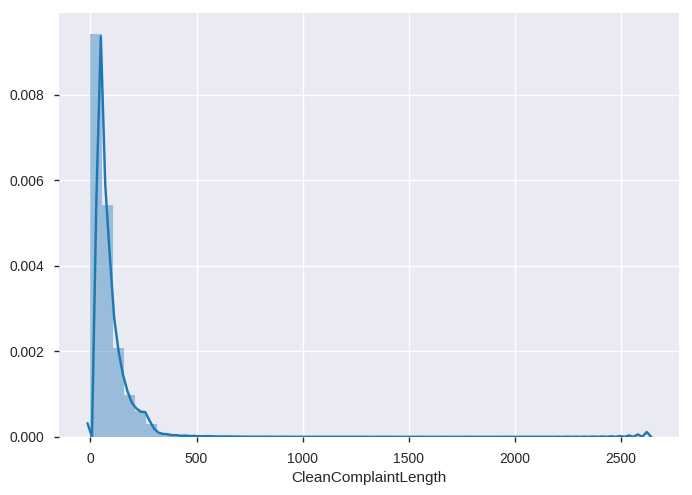

In [25]:
sns.distplot(dataN["CleanComplaintLength"]);

Text(0.5,1,'Complaint Lenghts')

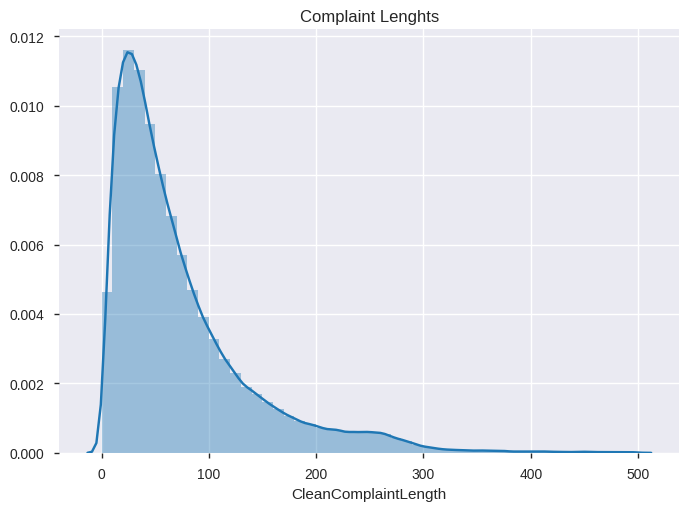

In [26]:
sns.distplot(dataN[dataN.CleanComplaintLength<500]["CleanComplaintLength"]);
import matplotlib.pyplot as plt

plt.title('Complaint Lenghts')


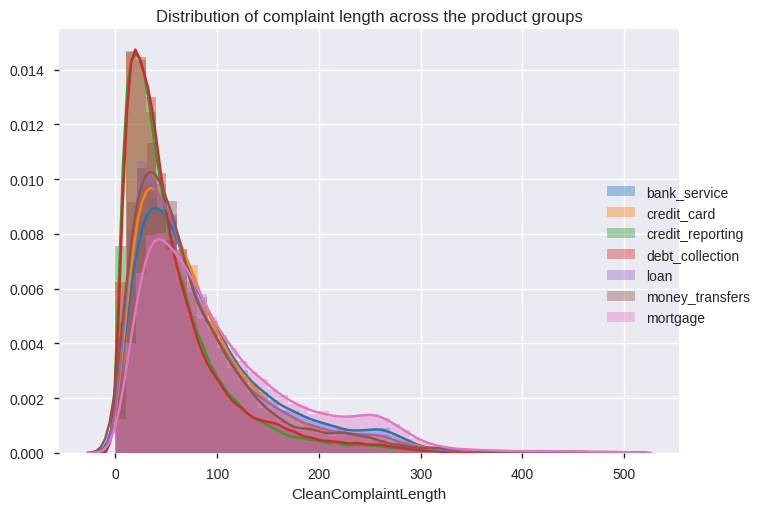

In [27]:
import matplotlib.pyplot as plt


unique_vals = dataN.product_group.unique()  

# Sort the dataframe by target
# Use a list comprehension to create list of sliced dataframes
targets = [dataN.loc[dataN['product_group'] == val] for val in unique_vals]
fig, ax = plt.subplots(1,1)
# Iterate through list and plot the sliced dataframe
for target in targets:
    sns.distplot(target[target.CleanComplaintLength<500]['CleanComplaintLength'], hist=True, rug=False, )

plt.title('Distribution of complaint length across the product groups')
fig.legend(labels=unique_vals, loc='center right')

#### Summary table of Complaint length

In [28]:
pd.DataFrame(dataN.groupby(['product_group'])['CleanComplaintLength'].agg(['mean','median', 'count']).sort_values(by=['median']))

,mean,median,count
product_group,,,
credit_reporting,59.118339,41,73991
debt_collection,60.828983,41,59994
money_transfers,81.146692,58,4731
loan,83.476335,61,30974
credit_card,84.595234,64,29459
bank_service,91.371662,69,20037
mortgage,110.283769,82,40237


Majority of the complaints have less than 400 tokens. Mortgage had the median longest complaints.

## WordCloud EDA by Product group

Next let's explore the dominant words for the different product groups

In [29]:
dataN.head()

,complaint_id,product_group,text,category_id,Corpus,CleanComplaintLength,Tokens
0,2815595,bank_service,On XX/XX/2017 my check # XXXX was debited from...,0,"[check, debit, check, account, check, cash, re...",22,"[on, xx, xx/2017, my, check, xxxx, was, debite..."
1,2217937,bank_service,I opened a Bank of the the West account. The a...,0,"[open, bank, west, account, account, come, pro...",32,"[i, opened, a, bank, of, the, the, west, accou..."
2,2657456,bank_service,wells fargo in nj opened a business account wi...,0,"[well, fargo, nj, open, business, account, aut...",22,"[wells, fargo, in, nj, opened, a, business, ac..."
3,1414106,bank_service,A hold was placed on my saving account ( XXXX ...,0,"[hold, place, save, account, institution, say,...",92,"[a, hold, was, placed, on, my, saving, account..."
4,1999158,bank_service,Dear CFPB : I need to send a major concern/com...,0,"[dear, cfpb, need, send, major, concern, compl...",253,"[dear, cfpb, i, need, to, send, a, major, conc..."


In [30]:
dataN.shape[0]

259423

In [31]:
# due to limited computer memory Sample 30K of the observations

In [32]:
####df = dataN.sample(n=30000, random_state=100)

In [33]:
df = dataN.copy()

bank_service


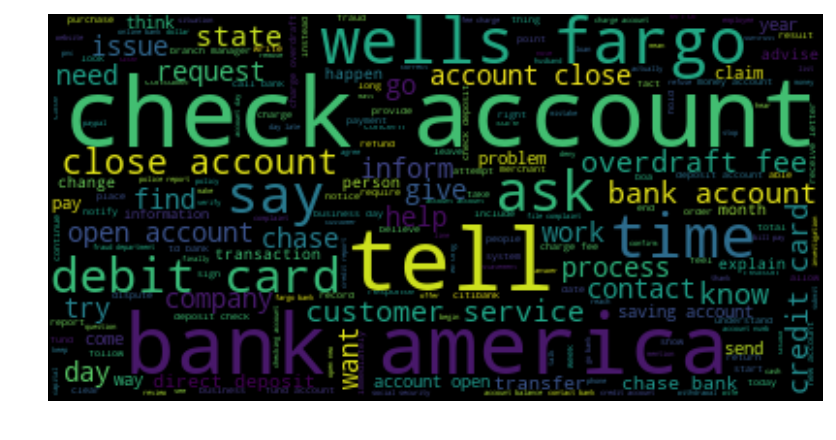

credit_card


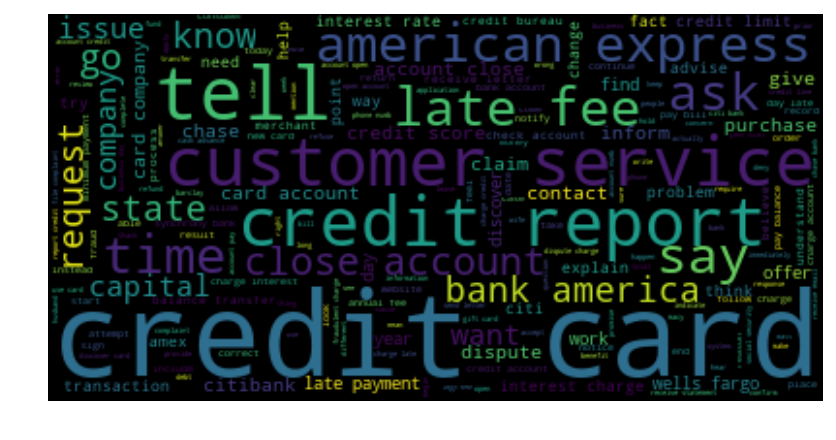

credit_reporting


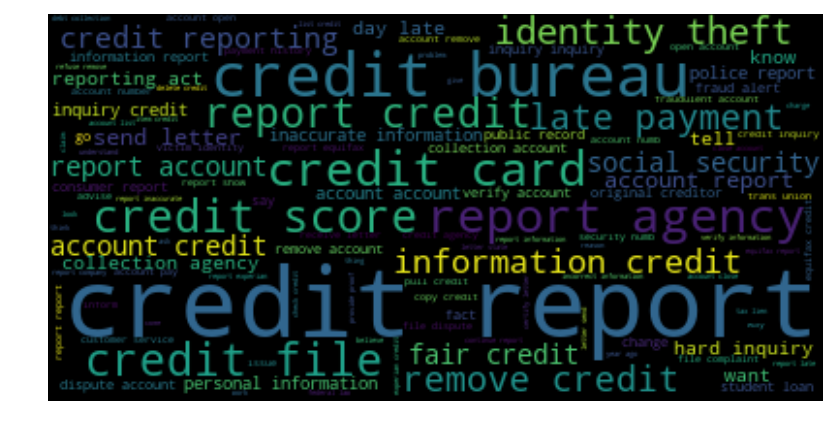

debt_collection


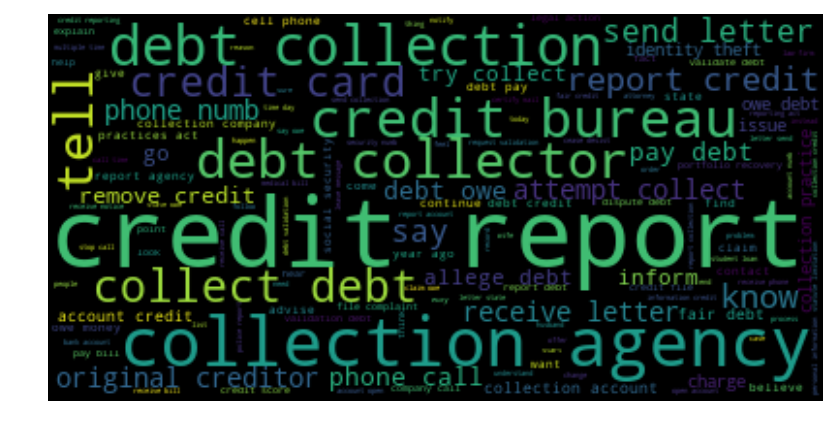

loan


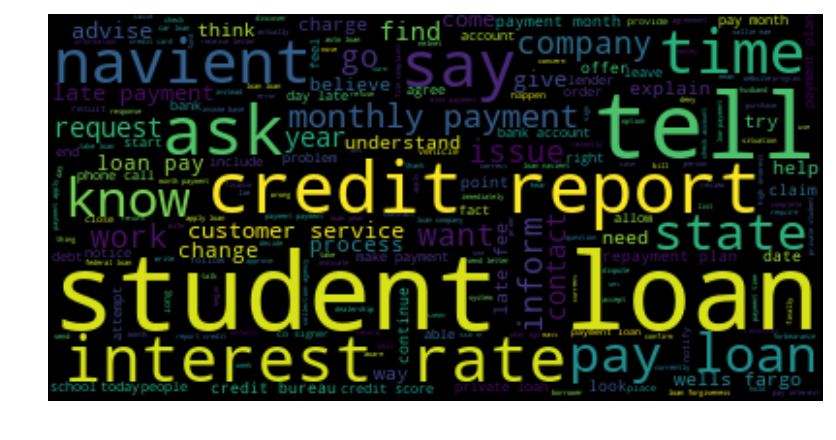

money_transfers


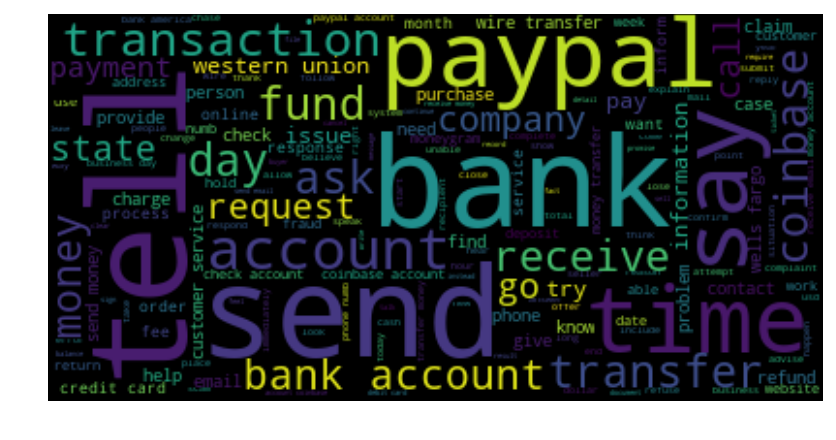

mortgage


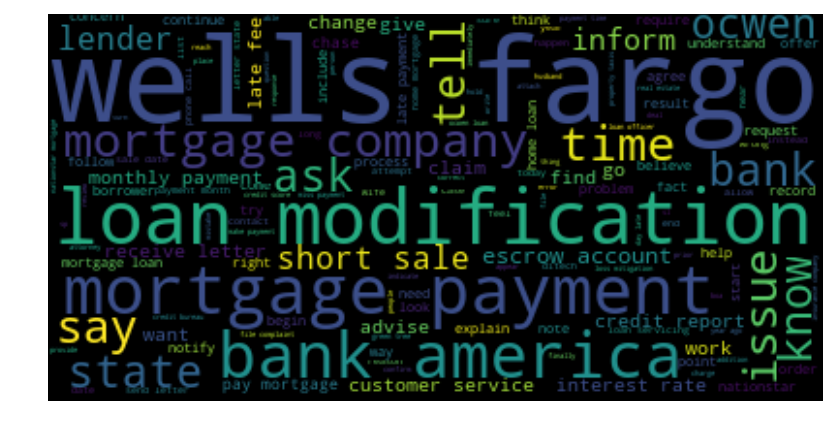

In [40]:
# diplay word cloud for the different product groups
for i in np.unique(WordClouds.Product_Group):
    fig, ax = plt.subplots(figsize=(10,7))
    temp = WordClouds[WordClouds.Product_Group==i]
    print(i)
    join_Words = " "
    join_Words = join_Words.join(temp.Word)  #Words for positive sentiments
    # Generate a word cloud image
    wordcloud_pos = WordCloud(max_font_size=70).generate(join_Words)
    plt.imshow(wordcloud_pos, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## Feature Engineering Special Bigrams from the word Clouds

This section was revisited after initial classfication where significant misclassfication was noted for `Credit Card`, `Credit Report`, `Debt Collection` and `loans` products.

Based on the word clouds above, below bigrams are identified as potential features to include in out classifiers to discriminate between the obove product groups.
* Credit Card - 'Late fee'
* Credit Report - 'credit report'
* Debt Collection - 'collection agency', 'debt collector', 'debe collection', and 'collect debt'
* Loans - 'student loans', and  'interest rate'

Using spacy a customised `Rule based matching` is created below to pull above biagrams.

In [62]:
df.head()

,complaint_id,product_group,text,category_id,Corpus,CleanComplaintLength,Tokens
0,2815595,bank_service,On XX/XX/2017 my check # XXXX was debited from...,0,"[check, debit, check, account, check, cash, re...",22,"[on, xx, xx/2017, my, check, xxxx, was, debite..."
1,2217937,bank_service,I opened a Bank of the the West account. The a...,0,"[open, bank, west, account, account, come, pro...",32,"[i, opened, a, bank, of, the, the, west, accou..."
2,2657456,bank_service,wells fargo in nj opened a business account wi...,0,"[well, fargo, nj, open, business, account, aut...",22,"[wells, fargo, in, nj, opened, a, business, ac..."
3,1414106,bank_service,A hold was placed on my saving account ( XXXX ...,0,"[hold, place, save, account, institution, say,...",92,"[a, hold, was, placed, on, my, saving, account..."
4,1999158,bank_service,Dear CFPB : I need to send a major concern/com...,0,"[dear, cfpb, need, send, major, concern, compl...",253,"[dear, cfpb, i, need, to, send, a, major, conc..."


In [4]:
# Perform standard imports
import spacy
nlp = spacy.load('en_core_web_sm')

In [41]:
from collections import defaultdict
from spacy.matcher import PhraseMatcher
matcher = PhraseMatcher(nlp.vocab)
dict_ =defaultdict(list)

# First, create a list of match phrases:
phrase_list = ['credit card','check account','debt collection', 'debt collector', 'collect debt', 'collection agency'
              'student loans', 'interest rate', 'loan modification', 'mortgage company', 'pay loan', 'short sale', 'mortgage payment',
              'bank account', 'monthly payment', 'collection bureau', 'debt card', 'western union', 'money transfer',
              'wire transfer', 'loan pay', 'customer service', 'american express', 'overdraft fee', 'report agency', 'debt card'
              ]
Bigrams_List = []
for i in df.text:
    #Applying the matcher to a Doc object
    doc = nlp(i)
    #print(df.text[i])

    # Next, convert each phrase to a Doc object:
    phrase_patterns = [nlp(text.lower()) for text in phrase_list]

    # Pass each Doc object into matcher (note the use of the asterisk!):
    matcher.add('Bigrams', None, *phrase_patterns)
    
    Temp_list =[]
    # Build a list of matches:
    matches = matcher(doc)
    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]  # get string representation
        span = doc[start:end]                    # get the matched span
        Temp_list =Temp_list + [span.text]
    
    Bigrams_List = Bigrams_List +[Temp_list]


In [42]:
len(Bigrams_List)

259423

In [43]:
df['Bigrams'] = Bigrams_List

From Word clouds above, some common Bigrams Dominate most the of the product groups. There is a lot of overlap between common words used in `Credit Cards`, `Credit Reporting` and `debt collection`. This high correlation can lead to missclassification of complaints between this three product groups. 

### Topic modeling with Unigrams and Bigrams

Below  LDA is explored as another non supervised approach to discover latent topics in the Customer complaints. Both Unigrams and Bigrams are used with 7 topics one for each product group.

In [37]:
# Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [96]:
def convert(list): 
    '''
   Function to contents of a list to string
    '''
      
    # Converting integer list to string list 
    content = [str(i) for i in list] 
      
    return(content) 

In [98]:
def LatentDirichletAllocation_Run(Corpus=convert(df['Corpus']), NoOfTopics =7, 
                                  TopWords = 7, show =False, LearningDecay = 0.3):
    '''
    Function to run LDA - LatentDirichletAllocation for topic modeling.
    *****************
    Inputs:
     - Corpus = Body of clean documents to identify topics
     - NoOfTopics = Number of topics
     - TopWords = Number of top words to display per topic
    ******************
    The function:
    1. Takes a Corpus and vectorizes it using Sklearn CountVectorizer
    2. Fits LDA on the data to identify topics
    3. Returns a dataframe with the corpus and topic assigned  
    
    '''
    Topic =pd.DataFrame()
    # vectorize data
    #cv = TfidfVectorizer(max_df=0.90, min_df=10, ngram_range=(1,1))
    cv = CountVectorizer(min_df=10, max_df=0.95, ngram_range=(2,2))

    #vectorize the data
    dtm = cv.fit_transform(Corpus)
    print(dtm.shape)
    
    # Latent Dirichlet Allocation Model
    LDA = LatentDirichletAllocation(n_components=NoOfTopics,learning_decay=LearningDecay,random_state=100, max_iter=10)
    
    # This can take awhile, we're dealing with a large amount of documents!
    X_Topics =LDA.fit(dtm)
    #X_Topics =TFIDF.fit(dtm)
    
    # number of features /words
    print("-------------------------------------------------------")
    print("                   Topics Summary                      ")
    print("-------------------------------------------------------")
    print("Number of Features/Words :", len(cv.get_feature_names()))
    print("Number of Topics:", len(LDA.components_))
    print("-------------------------------------------------------")
    Words_topics = pd.DataFrame() #Sortd
    temp_topic =pd.DataFrame() #sorted
    WordCloud = pd.DataFrame()
    temp_wordcloud = pd.DataFrame()
    n= 0
    if( show ==True):
        for index,topic in enumerate(LDA.components_):
            print(f'THE TOP {TopWords} WORDS FOR TOPIC #{index}')
            print([cv.get_feature_names()[i] for i in topic.argsort()[-TopWords:]])
            Sortedwords = [[cv.get_feature_names()[i] for i in topic.argsort()[-TopWords:]]]
            temp_topic["Topic"] = "Topic_"+str(n)
            temp_topic["Top5Words"] =list(Sortedwords)[0][0:15]
            temp_wordcloud["Topic"] = "Topic_"+str(n)
            temp_wordcloud["Words"] =list(Sortedwords)
            Words_topics = pd.concat([Words_topics, temp_topic], axis=0)
            WordCloud = pd.concat([WordCloud, temp_wordcloud], axis=0)
            WordCloud['Topic'] = WordCloud['Topic'].replace('nan', np.nan).fillna('Topic_0')
            Words_topics['Topic'] = Words_topics['Topic'].replace('nan', np.nan).fillna('Topic_0')
            print('\n')
            n =n+1
    topic_results = LDA.transform(dtm)
    
    # column names
    topicnames = ["Topic" + str(i) for i in range(NoOfTopics)]

    # index names
    docnames = ["Complain_" + str(i) for i in range(len(Corpus))]
    
    Topic=pd.DataFrame(topic_results)
    Topic = Topic.round(5) 
    Topic.columns=topicnames
    #Topic['product_group'] = df.product_group
    #Topic.index=docnames
    Topic['Dominant_Topic'] = topic_results.argmax(axis=1) # Map topic to book
 
    
    return(Topic,LDA,cv, dtm, topic_results, Words_topics, WordCloud)

#run
Temp_LDA, lda, vectorizer_cv, data_vectorized_cv ,LdaTR, WordsTopics, WordCloud= LatentDirichletAllocation_Run( show =True)

(259423, 28)
-------------------------------------------------------
                   Topics Summary                      
-------------------------------------------------------
Number of Features/Words : 28
Number of Topics: 7
-------------------------------------------------------
THE TOP 7 WORDS FOR TOPIC #0
['collector interest', 'rate debt', 'report interest', 'card interest', 'credit card', 'rate credit', 'interest rate']


THE TOP 7 WORDS FOR TOPIC #1
['collection credit', 'collector credit', 'report debt', 'credit card', 'card credit', 'report credit', 'credit report']


THE TOP 7 WORDS FOR TOPIC #2
['collection credit', 'collector credit', 'report debt', 'collection debt', 'collector debt', 'debt collection', 'debt collector']


THE TOP 7 WORDS FOR TOPIC #3
['collector credit', 'report debt', 'collection credit', 'credit card', 'card credit', 'report credit', 'credit report']


THE TOP 7 WORDS FOR TOPIC #4
['debt credit', 'report credit', 'card collect', 'credit report', 'c

In [102]:
data2 = df.copy()
data2.index=Temp_LDA.index
data2 = data2.join(Temp_LDA)
data2.head(2)

,complaint_id,product_group,text,category_id,Corpus,CleanComplaintLength,Tokens,Bigrams,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Dominant_Topic
0,2815595,bank_service,On XX/XX/2017 my check # XXXX was debited from...,0,"[check, debit, check, account, check, cash, re...",22,"[on, xx, xx/2017, my, check, xxxx, was, debite...",[],0.14286,0.14286,0.14286,0.14286,0.14286,0.14286,0.14286,0
1,2217937,bank_service,I opened a Bank of the the West account. The a...,0,"[open, bank, west, account, account, come, pro...",32,"[i, opened, a, bank, of, the, the, west, accou...",[],0.14286,0.14286,0.14286,0.14286,0.14286,0.14286,0.14286,0


In [103]:
data2.columns

Index(['complaint_id', 'product_group', 'text', 'category_id', 'Corpus',
       'CleanComplaintLength', 'Tokens', 'Bigrams', 'Topic0', 'Topic1',
       'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Dominant_Topic'],
      dtype='object')

In [104]:
cols = ['complaint_id', 'product_group',  'category_id', 'Topic0', 'Topic1', 'Topic2', 'Topic3', 'Topic4',
       'Topic5', 'Topic6', 'Dominant_Topic']

In [105]:
data3 = data2[cols]

In [106]:
# top words per topic
# Top 5 Keywords for each Topic
df_top5words_stacked = pd.DataFrame(WordsTopics, columns=['Topic', 'Top5Words'])
df_top5words = df_top5words_stacked.groupby('Topic').agg(', \n'.join)
df_top5words.reset_index(level=0,inplace=True)

In [107]:
Topic0 = list(WordsTopics[WordsTopics.Topic=='Topic_0']['Top5Words'])
Topic1 = list(WordsTopics[WordsTopics.Topic=='Topic_1']['Top5Words'])
Topic2 = list(WordsTopics[WordsTopics.Topic=='Topic_2']['Top5Words'])
Topic3 = list(WordsTopics[WordsTopics.Topic=='Topic_3']['Top5Words'])
Topic4 = list(WordsTopics[WordsTopics.Topic=='Topic_4']['Top5Words'])
Topic5 = list(WordsTopics[WordsTopics.Topic=='Topic_5']['Top5Words'])
Topic6 = list(WordsTopics[WordsTopics.Topic=='Topic_6']['Top5Words'])

Summary = pd.DataFrame([Topic0,Topic1, Topic2, Topic3, Topic4, Topic5, Topic6])
Summary.index = ['Topic_0','Topic_1', 'Topic_2', 'Topic_3' , 'Topic_4'  ,'Topic_5', 'Topic_6' ]
names = list(Summary.columns)
names_=[]
for i in names:
    names_=names_+['UnigramorBigram_'+str(names[i])]
Summary.columns = names_
Summary.T

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6
UnigramorBigram_0,collector interest,collection credit,collection credit,collector credit,debt credit,report debt,credit card
UnigramorBigram_1,rate debt,collector credit,collector credit,report debt,report credit,card collect,report interest
UnigramorBigram_2,report interest,report debt,report debt,collection credit,card collect,debt collect,card interest
UnigramorBigram_3,card interest,credit card,collection debt,credit card,credit report,report collect,rate credit
UnigramorBigram_4,credit card,card credit,collector debt,card credit,card debt,debt credit,rate debt
UnigramorBigram_5,rate credit,report credit,debt collection,report credit,card credit,collect debt,rate interest
UnigramorBigram_6,interest rate,credit report,debt collector,credit report,credit card,credit report,interest rate


Text(0.5,1,'LDA Distributions Topics in Complaints by Product Group')

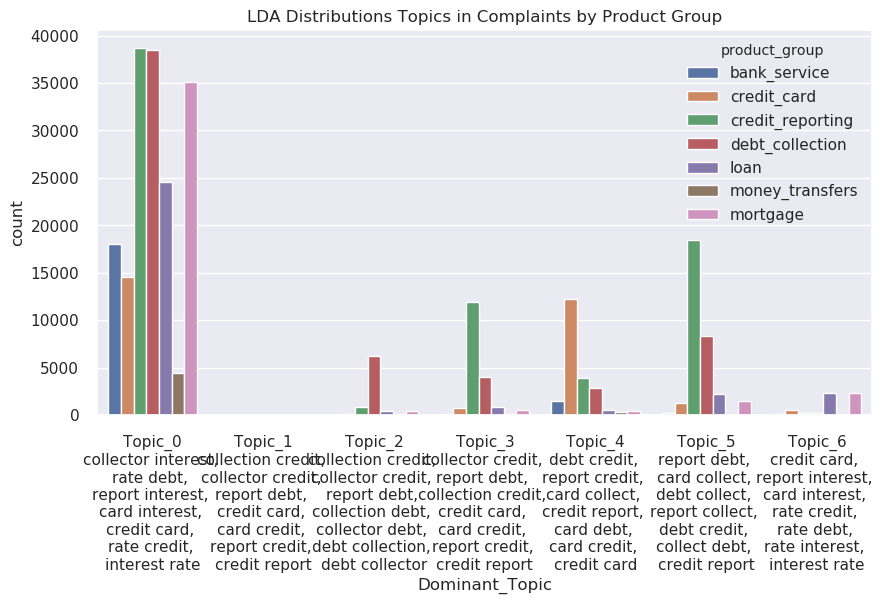

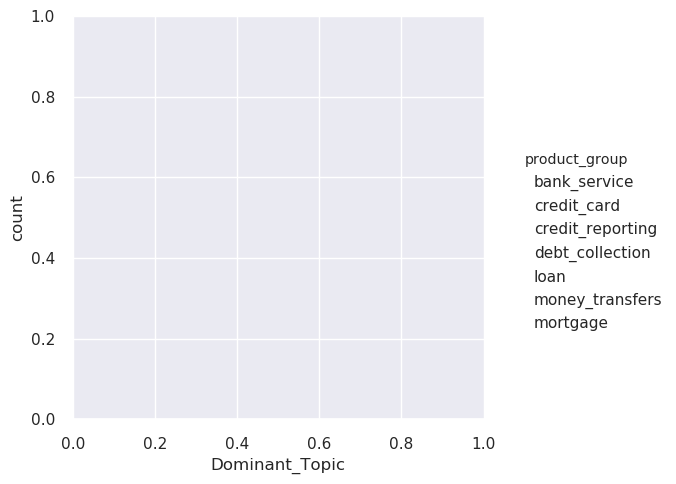

In [108]:
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(10,5))
sns.set_style("darkgrid")

sns.catplot(hue='product_group', x='Dominant_Topic',data=data3, kind="count",ax=ax);

ax.set_xticklabels(df_top5words.Topic+'\n'+df_top5words.Top5Words);
ax.set_title(r'LDA Distributions Topics in Complaints by Product Group')

In [109]:
data3.head()

,complaint_id,product_group,category_id,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Dominant_Topic
0,2815595,bank_service,0,0.14286,0.14286,0.14286,0.14286,0.14286,0.14286,0.14286,0
1,2217937,bank_service,0,0.14286,0.14286,0.14286,0.14286,0.14286,0.14286,0.14286,0
2,2657456,bank_service,0,0.14286,0.14286,0.14286,0.14286,0.14286,0.14286,0.14286,0
3,1414106,bank_service,0,0.14286,0.14286,0.14286,0.14286,0.14286,0.14286,0.14286,0
4,1999158,bank_service,0,0.07156,0.07143,0.07143,0.07143,0.57129,0.07143,0.07143,4


In [74]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
dash2 = pyLDAvis.sklearn.prepare(lda, data_vectorized_cv, vectorizer_cv, mds='tsne')
dash2

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1       29.005165  -11.849916       1        1  22.956203
3       12.626451 -101.735870       2        1  14.897152
0       98.659454  -70.977341       3        1  14.018342
4      -40.649036   47.277451       4        1  13.468474
6      115.038033   18.908743       5        1  12.222678
2      -57.027866  -42.608574       6        1  12.047953
5       45.383881   78.036186       7        1  10.389199, topic_info=      Category          Freq          Term         Total  loglift  logprob
10610  Default  13971.000000        report  13971.000000  30.0000  30.0000
3220   Default   8952.000000          debt   8952.000000  29.0000  29.0000
2979   Default  15131.000000        credit  15131.000000  28.0000  28.0000
6618   Default   3957.000000       inquiry   3957.000000  27.0000  27.0000
4404   Default   3876.000000       equifax   3876.000000  26.0000  26.0000
2328   Default   5438.000000    collection   5438.000000  25.0000  25.0000
116    Default  14586.000000       account  14586.000000  24.0000  24.0000
10533  Default   5546.000000        remove   5546.000000  23.0000  23.0000
1208   Default   6981.000000          bank   6981.000000  22.0000  22.0000
1836   Default   6646.000000          card   6646.000000  21.0000  21.0000
4655   Default   2747.000000      experian   2747.000000  20.0000  20.0000
7420   Default   8874.000000          loan   8874.000000  19.0000  19.0000
3805   Default   5457.000000       dispute   5457.000000  18.0000  18.0000
1767   Default   7140.000000          call   7140.000000  17.0000  17.0000
8113   Default   4649.000000      mortgage   4649.000000  16.0000  16.0000
12913  Default   2298.000000    transunion   2298.000000  15.0000  15.0000
9085   Default  10519.000000       payment  10519.000000  14.0000  14.0000
1689   Default   3481.000000        bureau   3481.000000  13.0000  13.0000
6540   Default   6994.000000   information   6994.000000  12.0000  12.0000
8042   Default   1848.000000  modification   1848.000000  11.0000  11.0000
11203  Default   2505.000000         score   2505.000000  10.0000  10.0000
4903   Default   3919.000000           fee   3919.000000   9.0000   9.0000
6182   Default   1997.000000      identity   1997.000000   8.0000   8.0000
391    Default   3687.000000        agency   3687.000000   7.0000   7.0000
7141   Default   4805.000000          late   4805.000000   6.0000   6.0000
12585  Default   1730.000000         theft   1730.000000   5.0000   5.0000
3362   Default   2201.000000        delete   2201.000000   4.0000   4.0000
6737   Default   3282.000000      interest   3282.000000   3.0000   3.0000
8925   Default   3834.000000           owe   3834.000000   2.0000   2.0000
3453   Default   1685.000000       deposit   1685.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
11970   Topic7    606.859175        status   1287.343383   1.5124  -5.4747
2979    Topic7   4597.760112        credit  15131.683288   1.0732  -3.4497
10533   Topic7   1994.782656        remove   5546.222395   1.2418  -4.2847
11506   Topic7   1237.313020          show   3116.282635   1.3407  -4.7623
2849    Topic7    898.509572       correct   2169.620167   1.3828  -5.0822
1689    Topic7   1286.198909        bureau   3481.848246   1.2685  -4.7235
12867   Topic7    260.546508         trans    487.080787   1.6388  -6.3202
6333    Topic7    618.218356    inaccurate   1473.732838   1.3957  -5.4561
5973    Topic7    543.114283       history   1249.408522   1.4313  -5.5857
3805    Topic7   1694.435227       dispute   5457.054617   1.0948  -4.4479
116     Topic7   3629.785356       account  14586.048046   0.8735  -3.6860
4404    Topic7   1279.733874       equifax   3876.061285   1.1562  -4.7286
7141    Topic7   1480.909232          late   4805.388309   1.0873  -4.5826
10345   Topic7    378.040029       reflect    798.164638   1

In [38]:
dataN.head()

,complaint_id,product_group,text,category_id,Corpus,CleanComplaintLength,Tokens
0,2815595,bank_service,On XX/XX/2017 my check # XXXX was debited from...,0,"[check, debit, check, account, check, cash, re...",22,"[on, xx, xx/2017, my, check, xxxx, was, debite..."
1,2217937,bank_service,I opened a Bank of the the West account. The a...,0,"[open, bank, west, account, account, come, pro...",32,"[i, opened, a, bank, of, the, the, west, accou..."
2,2657456,bank_service,wells fargo in nj opened a business account wi...,0,"[well, fargo, nj, open, business, account, aut...",22,"[wells, fargo, in, nj, opened, a, business, ac..."
3,1414106,bank_service,A hold was placed on my saving account ( XXXX ...,0,"[hold, place, save, account, institution, say,...",92,"[a, hold, was, placed, on, my, saving, account..."
4,1999158,bank_service,Dear CFPB : I need to send a major concern/com...,0,"[dear, cfpb, need, send, major, concern, compl...",253,"[dear, cfpb, i, need, to, send, a, major, conc..."


### data  for modeling

In [46]:
keep = ['complaint_id','text', 'product_group', 'category_id', 'Corpus', 'CleanComplaintLength', 'Bigrams']
modeling = df[keep]

In [47]:
#pickle data for modeling
pickle.dump(modeling, open( "data/modelingdata.p", "wb" ) , protocol=2) # save list as pickle

#### Environment info

In [214]:
%load_ext version_information
%version_information pandas, numpy, unipath, sklearn, spacy, matplotlib, wordcloud, pandas_profiling

Software,Version
Python,3.6.8 64bit [GCC 7.3.0]
IPython,7.2.0
OS,Linux 4.15.0 51 generic x86_64 with debian buster sid
pandas,0.24.2
numpy,1.16.2
unipath,1.1
sklearn,0.20.3
spacy,2.1.3
matplotlib,2.2.2
wordcloud,1.5.0
